In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone

import import_ipynb
import importlib
import ou_feature_engineering
# this is here to force reload of library - useful when editing library and testing it out.
#importlib.reload(ou_feature_engineering)

import warnings
warnings.filterwarnings("ignore")

importing Jupyter notebook from ou_feature_engineering.ipynb
importing Jupyter notebook from EDA_helpers.ipynb
importing Jupyter notebook from EDA_helpers.ipynb


In [2]:
df = pd.read_excel('wideform.xlsx')

# Currently, the dataframe has "2" as final result when a student withdraws. 
# We're just looking at pass/not pass, so I'm changing those "2"s to "1"s (not pass)
df.loc[df['final_result'] == 2, 'final_result'] = 1

# Feature for change between sum_clicks
df['sum_clicks_change'] = df['sum_click_pre_A2'] / df['sum_click_pre_A1']
# clip at 5 (500% - not sure if there is a meaningful difference for students who click more than 500%)
df['sum_clicks_change'] = np.clip(df['sum_clicks_change'],a_max=5, a_min=None)

# Don't think that log of clicks will make a difference for random forest, but if we decide on another
# model it might help.
#df['log_sum_clicks_change'] = np.log1p(df['sum_clicks_change'])

# Feature for whether student has taken other classes
df = ou_feature_engineering.add_col_student_prev_failed(df)
# Feature for if student's demographic info is outlier in course
df = ou_feature_engineering.add_col_demog_minority_in_course(df)

df.fillna(0, inplace=True)

In [3]:
def get_index():
    return ['code_module', 'code_presentation', 'id_student']

def get_label():
    return ['final_result']

# added in full list of possible features here - for easy removal/adding
def get_features():
    features = ['weighted_score_A2',
            #'score_A2',
            #'date_submitted_A2',
            'days_from_due_A2',
            'weighted_score_A1',
            #'score_A1',
            'sum_click_pre_A2',
            #'homepage_46-60',
            'days_from_due_A1',
            'sum_clicks_change',
            #'log_sum_clicks_change',
            #'date_submitted_A1',
            #'oucontent_46-60',
            #'oucontent_31-45',
            'sum_click_pre_A1',
            #'homepage_16-30',
            #'homepage_31-45',
            #'date_registration',
            #'url_46-60', 
            #'homepage_1-15', 
            #'oucontent_1-15', 
            #'oucontent_pre-0',
            #'oucontent_16-30',
            #'homepage_pre-0',
            #'studied_credits',
            #'subpage_16-30', 
            #'subpage_46-60', 
            'forumng_31-45', 
            #'glossary_46-60', 
            #'subpage_1-15',
            'forumng_46-60', 
            'forumng_1-15',
            'forumng_16-30',
            #'subpage_pre-0',
            #'url_1-15', 
            #'resource_1-15', 
            #'url_pre-0',
            #'resource_pre-0', 
            #'subpage_31-45', 
            #'url_31-45', 
            #'forumng_pre-0', 
            #'url_16-30', 
            #'oucollaborate_16-30', 
            'gender', 
            #'resource_16-30', 
            #'glossary_pre-0', 
            #'dataplus_31-45', 
            'age_band',
            #'glossary_16-30', 
            #'resource_46-60', 
            #'resource_31-45', 
            #'num_of_prev_attempts',
            #'oucollaborate_pre-0', 
            'highest_education',
            #'dataplus_pre-0', 
            #'glossary_31-45', 
            #'oucollaborate_1-15',
            'demog_minority_in_course',
            'disability', 
            #'glossary_1-15', 
            #'dataplus_1-15', 
            #'dataplus_16-30',
            #'dataplus_46-60', 
            #'dualpane_pre-0',
            #'dualpane_1-15',
            #'dualpane_16-30',
            #'dualpane_31-45',
            #'dualpane_46-60',
            #'externalquiz_pre-0',
            #'externalquiz_1-15',
            #'externalquiz_16-30',
            #'externalquiz_31-45',
            #'externalquiz_46-60',
            #'htmlactivity_pre-0',
            #'htmlactivity_1-15',
            #'htmlactivity_16-30',
            #'htmlactivity_31-45',
            #'htmlactivity_46-60',
            #'oucollaborate_31-45',
            #'oucollaborate_46-60',
            #'ouelluminate_pre-0',
            #'ouelluminate_1-15',
            #'ouelluminate_16-30',
            #'ouelluminate_31-45',
            #'ouelluminate_46-60',
            #'ouwiki_pre-0',
            #'ouwiki_1-15',
            #'ouwiki_16-30',
            #'ouwiki_31-45',
            #'ouwiki_46-60',
            #'page_pre-0',
            #'page_1-15',
            #'page_16-30',
            #'page_31-45',
            #'page_46-60',
            #'questionnaire_pre-0',
            #'questionnaire_1-15',
            #'questionnaire_16-30',
            #'questionnaire_31-45',
            #'questionnaire_46-60',
            #'quiz_pre-0',
            #'quiz_1-15',
            #'quiz_16-30',
            #'quiz_31-45',
            #'quiz_46-60',
            #'repeatactivity_pre-0',
            #'repeatactivity_1-15',
            #'repeatactivity_16-30',
            #'repeatactivity_31-45',
            #'repeatactivity_46-60',
            #'sharedsubpage_pre-0',
            #'sharedsubpage_1-15',
            #'sharedsubpage_16-30',
            #'sharedsubpage_31-45',
            #'sharedsubpage_46-60',
            'prev_failed_or_withdrawn'
            ]
    return features

def get_all_features(df, not_features = ['code_module', 'code_presentation', 'id_student', 'final_result', 'date_unregistration','probability']):
    return [col for col in df.columns if col not in not_features]

In [4]:
# create train test split for all dfs
# same as df_a, df_b,... df_f, but now we can iterate easily through each
def get_df_dict(df_all_modules):
    df_dict = {}
    df_dict['a'] = df[df['code_module'] == 'AAA'] # 704 rows
    df_dict['b'] = df[df['code_module'] == 'BBB'] # 6023 rows
    df_dict['c'] = df[df['code_module'] == 'CCC'] # 2451 rows
    df_dict['d'] = df[df['code_module'] == 'DDD'] # 4862 rows
    df_dict['e'] = df[df['code_module'] == 'EEE'] # 2297 rows
    df_dict['f'] = df[df['code_module'] == 'FFF'] # 6257 rows
    df_dict['all'] = df
    return df_dict

# return train test dicts for all modules in df_dict
def get_train_test_df_dicts(df, features = None, label = None):
    if features is None:
        features = get_features()
    if label is None:
        label = get_label()
    df_dict = get_df_dict(df)
    X_train = {}
    X_test = {}
    y_train = {}
    y_test = {}
    for module in df_dict.keys():
        X_train[module], X_test[module], y_train[module], y_test[module] = train_test_split(df_dict[module][features], df_dict[module][label], test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [5]:
def get_train_test_dicts_by_presentation(df, features = None, label = None):
    if features is None:
        features = get_features()
    if label is None:
        label = get_label()
    df_dict = get_df_dict(df)
    X_train = {}
    X_test = {}
    y_train = {}
    y_test = {}

    for module in df_dict.keys():
        presentations = df_dict[module].code_presentation.unique().tolist()
        test_presentation = presentations.pop()
        train_presentations = presentations

        train_df = df_dict[module][df_dict[module].code_presentation.isin(train_presentations)]
        test_df = df_dict[module][df_dict[module].code_presentation.isin([test_presentation])]

        X_train[module] = train_df[features].copy()
        X_test[module] = test_df[features].copy()
        y_train[module] = train_df[label].copy()
        y_test[module] = test_df[label].copy()

    return X_train, X_test, y_train, y_test

In [6]:
# Run Random Search CV on training data for each module in df. 
# If rerun is False, read most recent run of best hyper parameters from rf_best_params.json. 
# If no features are passed, uses smaller set of features from get_features() function.
def get_best_params_all(df, estimator=None, features = None, grid=None, random_state=42, rerun=False, n_iter=10):
    # use RandomForestClassifier if none provided
    if estimator is None:
        estimator = RandomForestClassifier(n_jobs=-1)
    
    file_name = str(type(estimator).__name__)+"_best_params.json"
    
    # read best parameters from file if rerun=False
    if rerun==False:
        results = pd.read_json(file_name, dtype='object').T
        # convert to integers where needed
        int_cols = ['min_samples_leaf','max_depth','n_estimators']
        for col in int_cols:
            if col in results.columns:
                results[col] = results[col].astype(int)
        return results

    # find best parameters for each module
    X_train, X_test, y_train, y_test = get_train_test_df_dicts(df, features=features)
    
    if grid == None:
        if type(estimator) == RandomForestClassifier:
            grid = {
                'criterion':['gini'],
                'min_samples_leaf':[3,4,5,6,7,8,9,10],
                'max_depth':[2,3,4,5,6,7,8,9,10,15,20,30,40,50,60],
                'max_features':['sqrt']
            }
        elif type(estimator) == GradientBoostingClassifier:
            grid = {
                'n_estimators':[5,10,15,25,50,100, 200, 400],
                'learning_rate':[0.1, 0.05, 0.25, 0.5, 1],
            }
    
    results = {}
    for key in X_train.keys():
        print("Starting ", type(estimator).__name__,"'s random search CV for module: ",key)
        clf = RandomizedSearchCV(estimator=estimator, param_distributions=grid, random_state=random_state, n_iter=n_iter)
        search_results = clf.fit(X_train[key],y_train[key])
        results[key] = search_results
        print("For module",key,"\n\tBest params: ",results[key].best_params_,"\n\tBest score: ",results[key].best_score_)
    
    # save off best params for future use
    best_params_dict = {k:v.best_params_ for k,v in results.items()}
    pd.DataFrame(best_params_dict).to_json(file_name)
    return best_params_dict
    #return results

In [7]:
# This function gets the best parameters for each module, uses the features given 
# and then evaluates the models using accuracy_by_module.
# If rerun is False (default), it just reads the best_params from a file.
# Returns a dictionary keyed by module 'a', 'b', ..., 'all' which has the 
#   accuracy score, top features, probabilities, and training accuracy for each module
def model_best_scores(df, estimator=None, features = None, rerun=False, n_iter=10):
    if features is None:
        features = get_features()
    if estimator is None:
        estimator = RandomForestClassifier(n_jobs=-1)
    df_dict = get_df_dict(df)
    best_params = get_best_params_all(df, estimator=estimator, features=features, rerun=rerun, n_iter=n_iter)

    results = {}
    for key in df_dict.keys():
        print("Training classifier", type(estimator).__name__,"for module",key,"...")

        # clone estimator and assign the best parameters
        estimator_best_params = clone(estimator)
        estimator_best_params.set_params(**best_params.loc[key])
        # if estimator is a random forest, increase number of estimators - as it typically won't hurt generalization
        if type(estimator) == RandomForestClassifier:
            estimator_best_params.n_estimators = 1000

        score, top, with_proba, train_score = accuracy_by_module(key, features=features, estimator=estimator_best_params)
        results[key] = {}
        results[key]['score'] = score
        results[key]['top'] = top
        results[key]['with_proba'] = with_proba
        results[key]['train_score'] = train_score
    
    return results

In [8]:
def accuracy_by_module(module, df = df, features = None, estimator=None):
    if features is None:
        features = get_features()
    
    df_dict = get_df_dict(df)
    module_df = df_dict[module]
    
    X_train_dict, X_test_dict, y_train_dict, y_test_dict = get_train_test_df_dicts(df)

    X_train = X_train_dict[module]
    X_test = X_test_dict[module]
    y_train = y_train_dict[module].astype('int').to_numpy().ravel()
    y_test = y_test_dict[module].astype('int').to_numpy().ravel()

    # default to using random forest classifier if no estimator given
    if estimator is None:
        clf = RandomForestClassifier(n_estimators = n_estimators_, max_depth = max_depth_, max_features=max_features_, criterion=criterion_, min_samples_leaf=min_samples_leaf_, random_state=42)
        clf.fit(X_train, y_train)
    else:
        clf = estimator
        clf.fit(X_train, y_train)

    score = clf.score(X_test, y_test)
    train_score = clf.score(X_train, y_train)
    importances = list(clf.feature_importances_)
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(features, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    probabilities = clf.predict_proba(module_df[features])[:,1]
    module_df['probability'] = clf.predict_proba(module_df[features])[:,1]

    return score, feature_importances, module_df, train_score

In [9]:
# get results using only the smaller set of features
# set rerun=False to not go through Randomized Search CV search again
res = model_best_scores(df, features=get_features(), rerun=False)

Training classifier RandomForestClassifier for module a ...
Training classifier RandomForestClassifier for module b ...
Training classifier RandomForestClassifier for module c ...
Training classifier RandomForestClassifier for module d ...
Training classifier RandomForestClassifier for module e ...
Training classifier RandomForestClassifier for module f ...
Training classifier RandomForestClassifier for module all ...


In [10]:
# print out the scores using the smaller set of features
scores = [(k,v['score']) for k,v in res.items()]
scores

[('a', 0.7872340425531915),
 ('b', 0.7460580912863071),
 ('c', 0.814663951120163),
 ('d', 0.7677286742034943),
 ('e', 0.8630434782608696),
 ('f', 0.75),
 ('all', 0.7758353618057092)]

In [11]:
a_with_proba = res['a']['with_proba']
b_with_proba = res['b']['with_proba']
c_with_proba = res['c']['with_proba']
d_with_proba = res['d']['with_proba']
e_with_proba = res['e']['with_proba']
f_with_proba = res['f']['with_proba']
full_with_proba = res['all']['with_proba']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000237EFCC1C70>]],
      dtype=object)

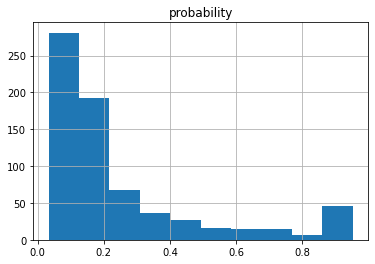

In [12]:
a_with_proba.hist(column='probability')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000237EFAE8C40>]],
      dtype=object)

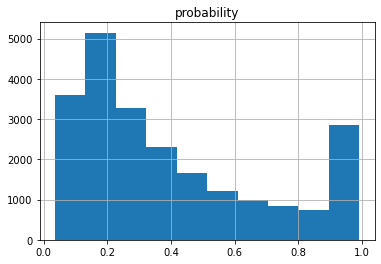

In [18]:
full_with_proba.hist(column='probability')

In [13]:
generalized_predictions_df = full_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()

generalized_predictions_df

,code_module,code_presentation,id_student,probability
0,AAA,2013J,11391,0.152034
1,AAA,2013J,28400,0.223882
2,AAA,2013J,31604,0.111867
3,AAA,2013J,32885,0.744694
4,AAA,2013J,38053,0.304040
...,...,...,...,...
22589,FFF,2014J,2684048,0.980612
22590,FFF,2014J,2686035,0.426052
22591,FFF,2014J,2693932,0.116895
22592,FFF,2014J,2694139,0.623057


In [14]:
a_prob_df = a_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()
b_prob_df = b_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()
c_prob_df = c_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()
d_prob_df = d_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()
e_prob_df = e_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()
f_prob_df = f_with_proba[['code_module', 'code_presentation', 'id_student', 'probability']].copy()

class_specific_predictions = pd.concat([a_prob_df, b_prob_df, c_prob_df, d_prob_df, e_prob_df, f_prob_df], ignore_index=True)
class_specific_predictions

,code_module,code_presentation,id_student,probability
0,AAA,2013J,11391,0.072695
1,AAA,2013J,28400,0.126510
2,AAA,2013J,31604,0.040850
3,AAA,2013J,32885,0.603700
4,AAA,2013J,38053,0.116716
...,...,...,...,...
22589,FFF,2014J,2684048,0.987897
22590,FFF,2014J,2686035,0.406336
22591,FFF,2014J,2693932,0.134224
22592,FFF,2014J,2694139,0.658600


In [15]:
# Uncomment this code to re-save predictions

#generalized_predictions_df.to_excel("generalized_predicts.xlsx", index=False)
#class_specific_predictions.to_excel("class_specific_predicts.xlsx", index=False)

## Gradient Boosted Classifier

In [16]:
# reuse functions from before
gb_res = model_best_scores(df, estimator=GradientBoostingClassifier(), rerun=False)


Training classifier GradientBoostingClassifier for module a ...
Training classifier GradientBoostingClassifier for module b ...
Training classifier GradientBoostingClassifier for module c ...
Training classifier GradientBoostingClassifier for module d ...
Training classifier GradientBoostingClassifier for module e ...
Training classifier GradientBoostingClassifier for module f ...
Training classifier GradientBoostingClassifier for module all ...


In [17]:
# print out gb scores
gb_scores = [(k,v['score']) for k,v in gb_res.items()]
gb_scores

[('a', 0.8014184397163121),
 ('b', 0.7560165975103734),
 ('c', 0.8105906313645621),
 ('d', 0.7708119218910586),
 ('e', 0.8434782608695652),
 ('f', 0.7643769968051118),
 ('all', 0.7760566497012613)]